In [0]:
# https://www.kaggle.com/hmendonca/mask-rcnn-and-coco-transfer-learning-lb-0-155
#参考文献；https://github.com/mpsampat/DSB_2018_Parameter_Selection_For_Matterport_Mask_RCNN/blob/master/comparison_of_Matterport_Mask_RCNN_parameters.md

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
os.getcwd()

'/content'

In [4]:
!pip install pydicom
!pip install imgaug

    100% |████████████████████████████████| 7.3MB 6.1MB/s 
    100% |████████████████████████████████| 634kB 20.2MB/s 
  Running setup.py bdist_wheel for imgaug ... - \ done
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug


In [0]:
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

In [0]:
DATA_DIR = '/content/drive/My Drive/data'

# Directory to save logs and trained model
ROOT_DIR = '/content/drive/My Drive/data'

In [0]:
os.chdir('/content/drive/My Drive/data/Mask_RCNN')

In [8]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [0]:
train_dicom_dir = os.path.join(DATA_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_1_test_images') 

Download COCO pre-trained weights¶

In [9]:
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

-rw------- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5


In [0]:
#COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"
COCO_WEIGHTS_PATH = "/content/drive/My Drive/data/pneumonia20181023T2258/mask_rcnn_pneumonia_0003.h5"
#COCO_WEIGHTS_PATH = "/content/drive/My Drive/data/pneumonia20181017T0623/mask_rcnn_pneumonia_0023.h5"


Some setup functions and classes for Mask-RCNN¶
- dicom_fps is a list of the dicom image path and filenames
- image_annotions is a dictionary of the annotations keyed by the filenames
- parsing the dataset returns a list of the image filenames and the annotations dictionary

In [0]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))
# setは集合を表すデータ型で、リスト等と同様に複数の要素をもつことができる。集合なので、リストとは異なり要素は順番をもたない。また、重複した要素は取り除かれる。
# リスト化して、それぞれの順序を作成する

def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

#iterrows()メソッドを使うと、1行ずつ、インデックス名（行名）とその行のデータ（pandas.Series型）のタプル(index, Series)を取得できる。



In [12]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

#      """Configuration for training pneumonia detection on the RSNA pneumonia dataset. Overrides values in the base Config class."""

class DetectorConfig(Config):
  # Give the configuration a recognizable name  
  NAME = 'pneumonia'
    
  # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
  # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
  GPU_COUNT =1
  IMAGES_PER_GPU = 8

  BACKBONE = 'resnet50'
  #BACKBONE = 'resnet101'
  NUM_CLASSES = 2  # background + 1 pneumonia classes

  IMAGE_MIN_DIM = 256
  IMAGE_MAX_DIM = 256
  RPN_ANCHOR_SCALES = (32, 64, 96, 128)
 # RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)
 # RPN_TRAIN_ANCHORS_PER_IMAGE = 320
  TRAIN_ROIS_PER_IMAGE = 32
  MAX_GT_INSTANCES = 3
  DETECTION_MAX_INSTANCES = 3
  DETECTION_MIN_CONFIDENCE = 0.7  ## match target distribution
  DETECTION_NMS_THRESHOLD = 0.1
  #DETECTION_NMS_THRESHOLD = 0.3
  #DETECTION_MIN_CONFIDENCE = 0.5  ## match target distribution

  STEPS_PER_EPOCH = 206
  #STEPS_PER_EPOCH = 56**

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [12]:
# ver 002 
# These are not optimal 

#      """Configuration for training pneumonia detection on the RSNA pneumonia dataset. Overrides values in the base Config class."""
# STEPS_PER_EPOCH is basically just telling you how many images you're using, which is basically STEPS_PER_EPOCH * BATCH_SIZE * NUM_EPOCHS

class DetectorConfig(Config):
  # Give the configuration a recognizable name  
  NAME = 'pneumonia'
    
  # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
  # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
  GPU_COUNT =1
  IMAGES_PER_GPU = 8

  BACKBONE = 'resnet101'
  NUM_CLASSES = 2  # background + 1 pneumonia classes

  IMAGE_MIN_DIM = 256
  IMAGE_MAX_DIM = 256
  RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)
  RPN_TRAIN_ANCHORS_PER_IMAGE = 320
  TRAIN_ROIS_PER_IMAGE = 32
  MAX_GT_INSTANCES = 3
  DETECTION_MAX_INSTANCES = 3
  DETECTION_NMS_THRESHOLD = 0.3
  DETECTION_MIN_CONFIDENCE = 0.5  ## match target distribution

  STEPS_PER_EPOCH = 206

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [0]:
"""Dataset class for training pneumonia detection on the RSNA pneumonia dataset.

"""
class DetectorDataset(utils.Dataset):

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

Examine the annotation data, parse the dataset, and view dicom fields¶

In [14]:
# training dataset
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_1_train_labels.csv'))
anns.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [0]:
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)

In [0]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [0]:
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

In [18]:
# split dataset into training vs. validation dataset 
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = 1500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

24184 1500


Create and prepare the training dataset using the DetectorDataset class.¶

In [0]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

In [0]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()

Display a random image with bounding boxes¶

(1024, 1024, 3)
/content/drive/My Drive/data/stage_1_train_images/db8433df-a208-4416-a35d-d131d8e334e3.dcm
[1]


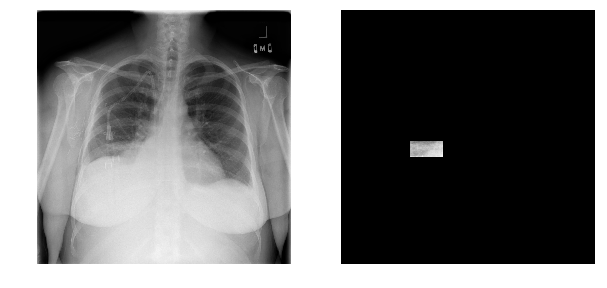

In [21]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)


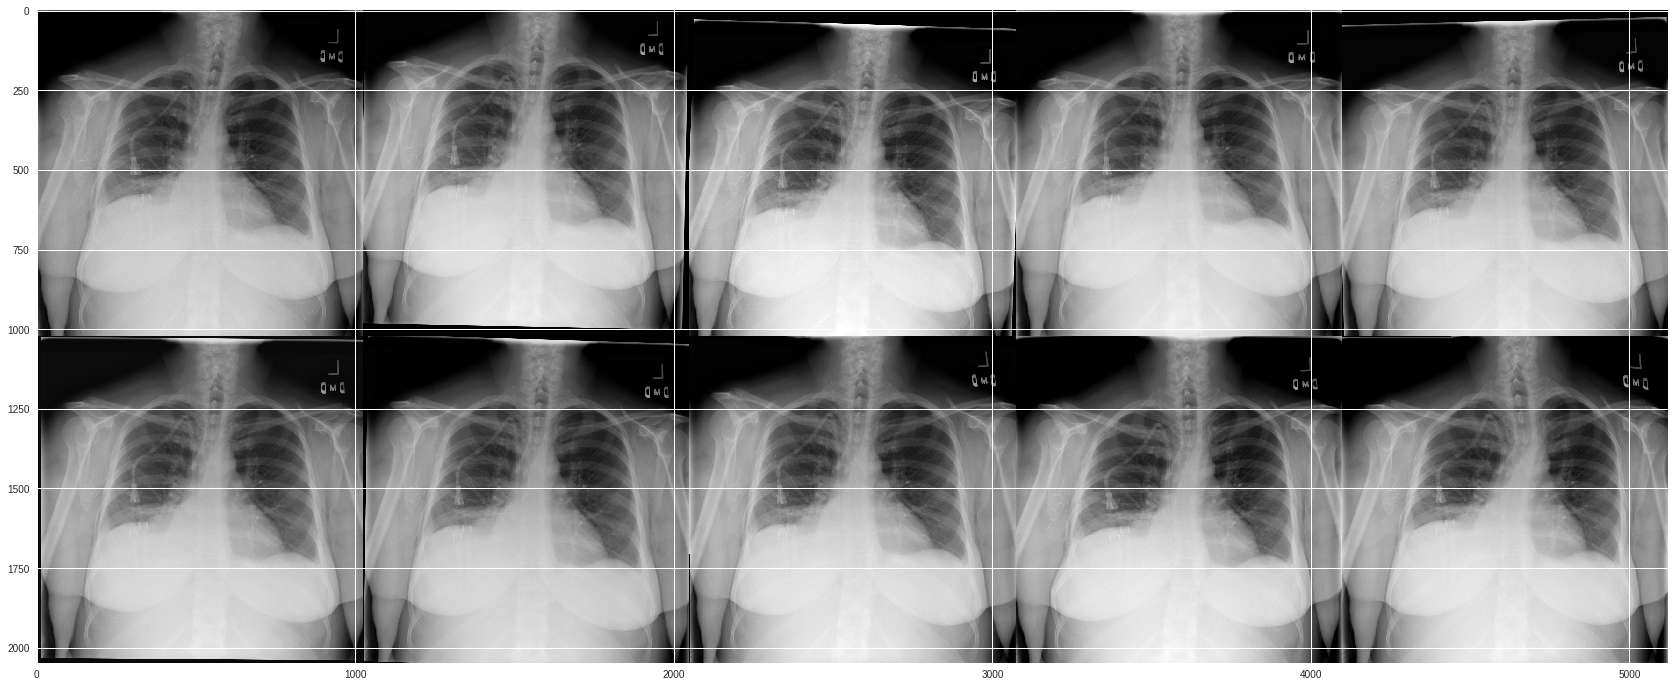

In [22]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.01, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

In [23]:
#Now it's time to train the model. Note that training even a basic model can take a few hours.¶
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

Re-starting from epoch 3


In [0]:
LEARNING_RATE = 0.0005

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [0]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=10,
            layers='all',
            augmentation=augmentation)

news = model.keras_model.history.history
for k in news: history[k] = history[k] + news[k]


Starting at epoch 3. LR=0.0001

Checkpoint Path: /content/drive/My Drive/data/pneumonia20181023T2258/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

ValueError: ignored

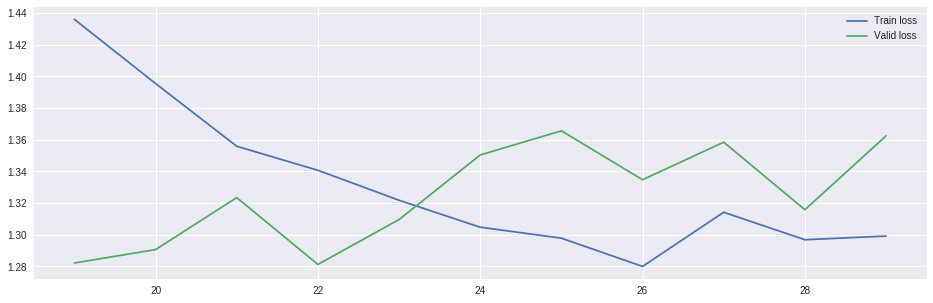

In [50]:
history = model.keras_model.history
plt.figure(figsize=(16,5))

plt.subplot(111)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(112)
plt.plot(history.epoch, history.history["mrcnn_class_loss"], label="Train class ce")
plt.plot(history.epoch, history.history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(113)
plt.plot(history.epoch, history.history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(history.epoch, history.history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [66]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/drive/My Drive/data/pneumonia20181017T0623/mask_rcnn_pneumonia_0030.h5


In [67]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/data/pneumonia20181017T0623/mask_rcnn_pneumonia_0030.h5
Re-starting from epoch 30


In [0]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

(256, 256, 3)

*** No instances to display *** 


*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 


*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 


*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 


*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 


*** No instances to display *** 



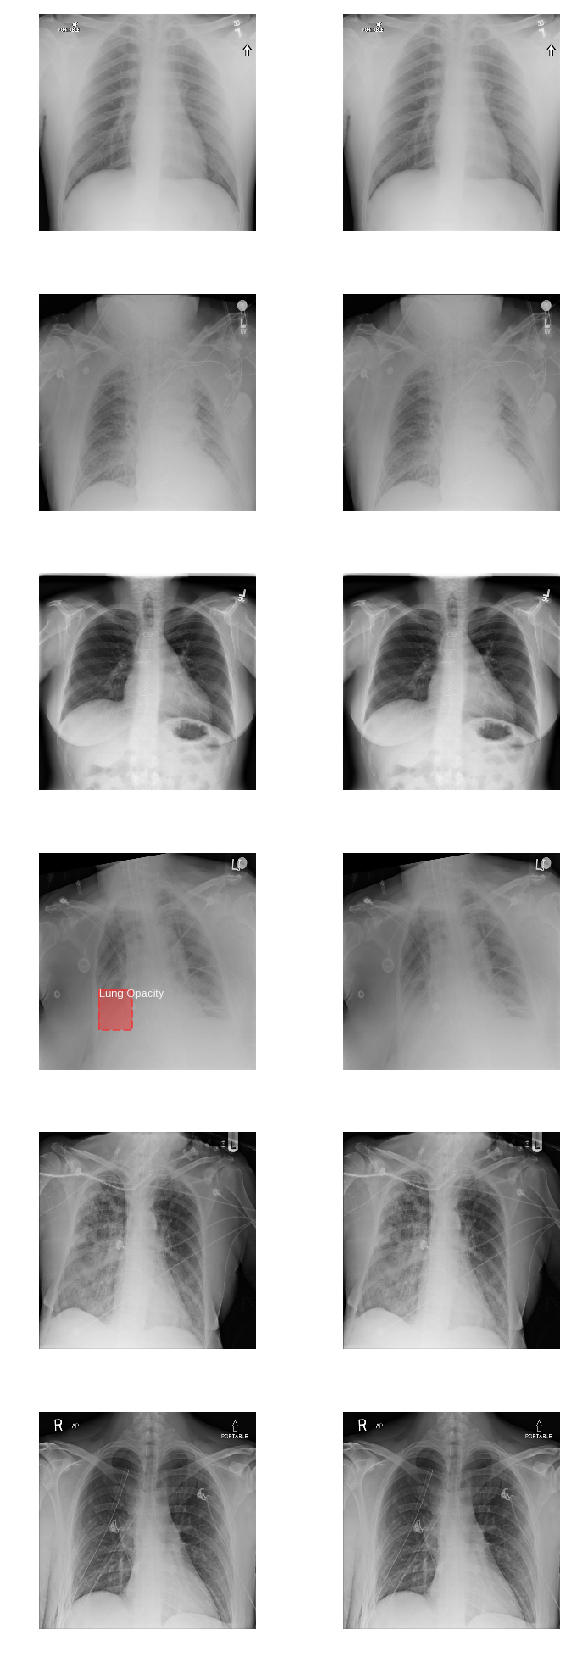

In [69]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [0]:
# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)

In [0]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.97):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")


In [72]:
submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 1000/1000 [03:02<00:00,  5.55it/s]

/content/drive/My Drive/data/submission.csv
